In [1]:
import sys
import os
os.chdir('../')

import itertools as it
import numpy as np
import pandas as pd
import pylab as py
import matplotlib.pyplot as plt
from  matplotlib import rc
from matplotlib.colors import LogNorm
%matplotlib inline

from tools.tools import save,load,lprint,load_config
from tools.bar import BAR

In [2]:
from fitlab.resman import RESMAN
from fitlab.parman import PARMAN

In [3]:
!ls inputs/boermulders.py

inputs/boermulders.py


In [4]:
conf=load_config('inputs/boermulders.py')
conf['resman']=RESMAN(conf)
conf['resman'].get_residuals(conf['parman'].par);

loading sidis data sets 5023

In [5]:
def get_binned_axis(dataframe, axis):
    return np.unique(dataframe[axis])

def create_rounded_variables(dataframe):
    dataframe['rounded_x'] = np.round(dataframe['x'], 2)
    dataframe['rounded_q2'] = np.round(dataframe['Q2'], 2)
    dataframe['rounded_y'] = np.round(dataframe['y'], 2)
    dataframe['rounded_z'] = np.round(dataframe['z'], 2)
    dataframe['rounded_pt'] = np.round(dataframe['pT'], 2)
    
def append_string_axis(dataframe):
    dataframe['axis'] = dataframe['axis'].astype('str')

In [6]:
datasets = {}

for index, data in conf['resman'].sidisres.tabs.iteritems():
    datasets[index] = pd.DataFrame(data) 
    create_rounded_variables(datasets[index])
    append_string_axis(datasets[index])

In [7]:
def get_subset(data, cuts):
    data_subset = data.query(cuts)
    return data_subset

def get_axis(data, axis): 
    return data.loc[data.axis == axis]

In [8]:
datasets.keys()

[5024, 5019, 5020, 5023]

In [9]:
get_binned_axis(datasets[5020], 'rounded_x')

array([ 0.1 ,  0.19])

In [10]:
def plot(data): 
        
    data_sub_x = get_axis(data, 'x')
    data_sub_z = get_axis(data, 'z')
    data_sub_pt = get_axis(data, 'pt')
    
    # options 
    plt.figure(figsize=(16,6))
    plt.rc('font', size=16)
    
    plt.subplot(1, 3, 1)
    plt.errorbar(x=data_sub_x['x'], y=data_sub_x.value, yerr=data_sub_x.alpha, 
                 marker='o', linestyle='', color='red')
    plt.plot(data_sub_x['x'], data_sub_x.thy, linestyle='-', color='red')
   
    plt.axhline(0.0, linestyle='--', color='black', alpha=0.4)
    plt.xlabel('$x_{Bjorken}$')
    plt.ylim([-0.12, 0.12])
    
    plt.subplot(1, 3, 2)
    plt.errorbar(x=data_sub_z['z'], y=data_sub_z.value, yerr=data_sub_z.alpha, 
                 marker='o', linestyle='', color='red')
    plt.plot(data_sub_z['z'], data_sub_z.thy, linestyle='-', color='red')

    plt.axhline(0.0, linestyle='--', color='black', alpha=0.4)
    plt.xlabel('$z_{h}$')
    plt.ylim([-0.12, 0.12])


    plt.subplot(1, 3, 3)
    plt.errorbar(x=data_sub_pt['pT'], y=data_sub_pt.value, yerr=data_sub_pt.alpha, 
                 marker='o', linestyle='', color='red')
    plt.plot(data_sub_pt['pT'], data_sub_pt.thy, linestyle='-', color='red')

    plt.axhline(0.0, linestyle='--', color='black', alpha=0.4)
    plt.xlabel('$P_{T}$')
    plt.ylim([-0.12, 0.12])


    plt.tight_layout()

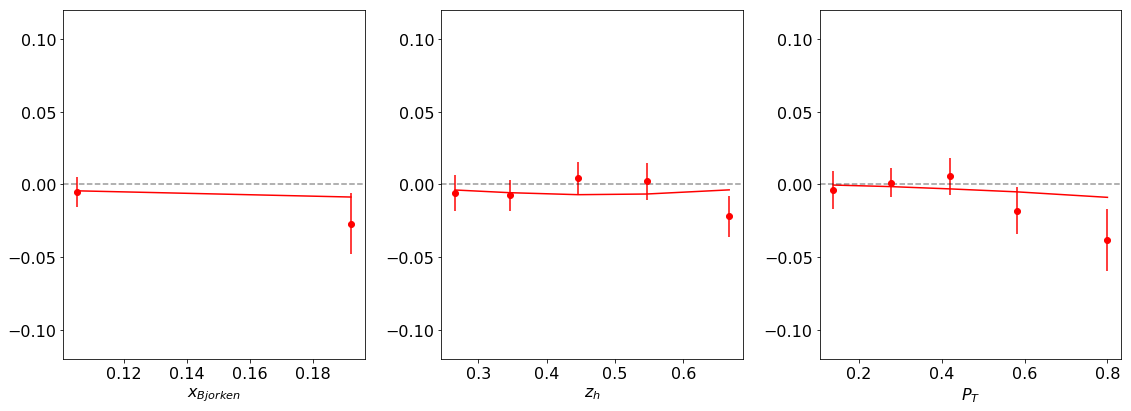

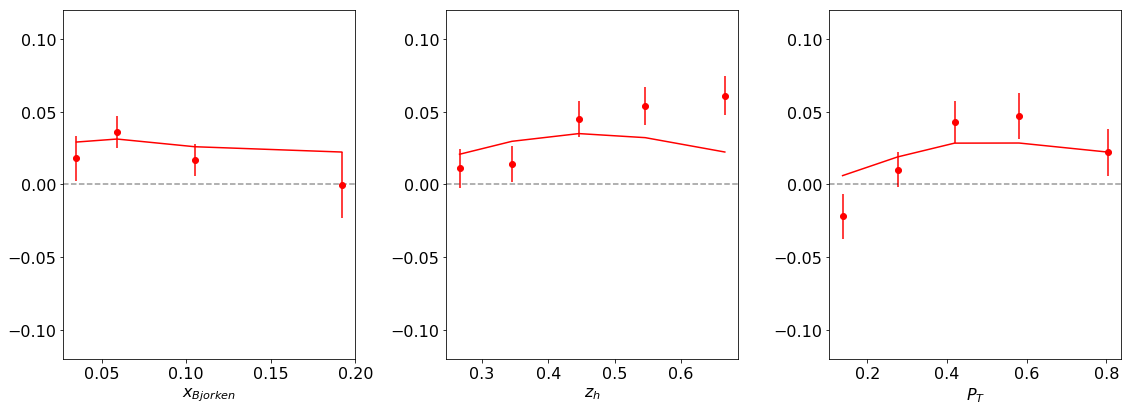

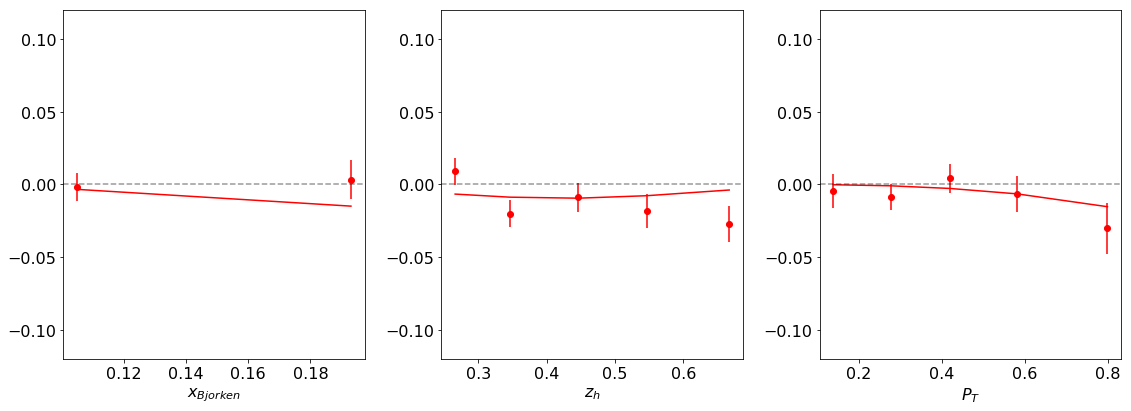

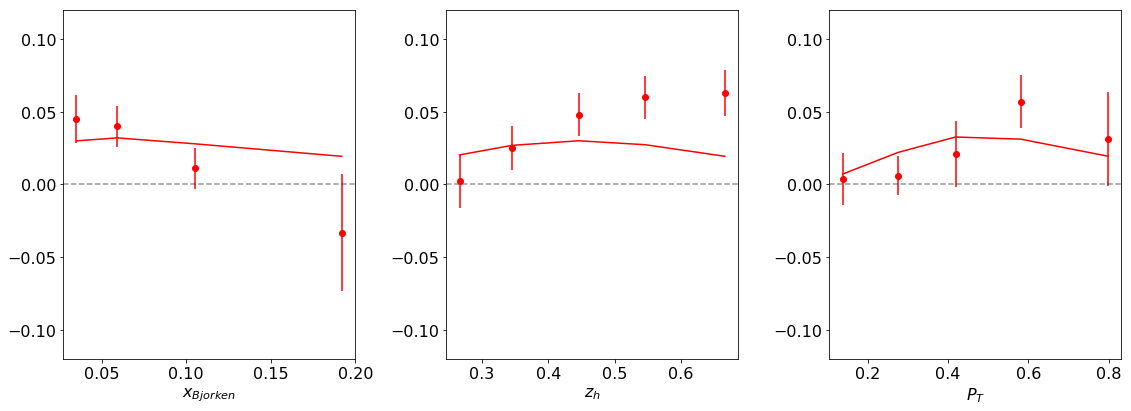

In [11]:
for index, data in datasets.iteritems():
    plot(data)
    
    figure_title = 'summary_plot_%d.pdf' % index
    plt.savefig(figure_title)

In [12]:
data_sub_x = get_axis(datasets[5019], 'x')